# Notebook 03: Modeling
#### Purpose:
The purpose of this notebook is to train a model to semantically segment aerial cityscape imagery.

#### Data:
The training data comes from the Varied Drone Dataset (VDD) and the Semantic Drone Dataset (SDD).

#### Process:
The modeling process that takes place is as follows:
1. Using a U-net architecture, perform a hyperparameter study for batch size (how many images are fed to the model for training at a time), the learning rate for the optimizer. The loss and accuracy is recoreded against the epoch during model training for analysis.
2. Making predictions using the best model tested.
3. Drawing conclusions.

### Imports

In [109]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

from keras.utils import to_categorical, normalize
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.callbacks import Callback, CSVLogger, EarlyStopping
from keras.optimizers import Adam

In [110]:
print(tf.__version__)

2.14.0


### Use GPU if exists

In [111]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Tensorflow will use GPU")
else:
    print("Tensorflow will use CPU")

Num GPUs Available:  0
Tensorflow will use CPU


### Functions

In [112]:
def get_image_data(folder, extension, image_shape):
    """
    Description
    -----------
    Loads images from folder into a single array.
    
    Parameters
    ----------
    folder : str
        the folder path (including trailing /).
    extension : str
        the file extension (i.g. .jpeg, .bmp).
    image_shape : tuple of int
        image height by image width in pixels.

    Returns
    -------
    image_list : numpy array
        loaded images stored in a numpy array.
    """
    image_list = []
    for directory_path in glob.glob(folder):
        for img_path in glob.glob(os.path.join(directory_path, "*" + extension)):
            img = cv2.imread(img_path, 0)  #being read as grayscale even though RGB
            img = cv2.resize(img, image_shape, interpolation=cv2.INTER_NEAREST)  # nearest neighbor interpolation to prevent creation of new mask values
            image_list.append(img)
           
    #Convert list to array for machine learning processing        
    return np.array(image_list)


def load_image_and_mask_data(image_folder, image_extension, mask_folder, mask_extension, image_shape):
    #Load and resize train images and masks
    images = get_image_data(image_folder, image_extension, image_shape)
    masks = get_image_data(mask_folder, mask_extension, image_shape)
    
    #Encode mask labels (enforces 0-indexed labeling)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    masks_1_dim = masks.reshape(-1,1).ravel()
    masks_1_dim_encoded = labelencoder.fit_transform(masks_1_dim)
    masks_encoded = masks_1_dim_encoded.reshape(n, h, w)
    
    #Expand image dimensions and normalize
    images_input = np.expand_dims(images, axis=3)  #(image, y, x, new_dimension)
    images_input = normalize(images_input, axis=1)  #normalize each image
    masks_expanded = np.expand_dims(masks_encoded, axis=3)  #(image, y, x, new_dimension)
    
    #Info
    class_values = np.unique(masks_expanded)
    n_classes = len(class_values)
    print("Class labels in the dataset are ... ", class_values)
    print("Number of classes in the dataset is ... ", n_classes)
    
    #One-hot encode mask classes
    masks_input = to_categorical(masks_expanded, num_classes=n_classes)
    
    #Calculate balanced class weights
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                     classes=class_values,
                                                     y=masks_1_dim_encoded)
    class_weights_dict = {}
    for ind, c in enumerate(np.unique(masks_1_dim_encoded)):
        class_weights_dict[c] = class_weights[c]
    print("Class weights dictionary looks like ...:", class_weights_dict)
    
    return images_input, masks_input, n_classes, class_weights_dict


def get_fold_indices(n_samples, n_folds):
    """
    Description
    -----------
    Splits n_samples indices into n_folds folds for cross-validation.
    
    Parameters
    ----------
    n_samples : int
        number of images in the training set to be used in the cross-validation.
    n_folds : int
        number of folds to split the training data into for cross-validation.

    Returns
    -------
    indices_by_fold : dict
        dictionary of image indices split into `n_folds` folds (each fold gets its own key).
    """
    x = n_samples // n_folds
    
    indices_by_fold = {}
    
    for n in range(n_folds):
        fold_n = [i for i in range(x*n, x*n+x)]
        
        if n == (n_folds-1):
            fold_n.extend([i for i in range(max(fold_n)+1,n_samples)])
        
        indices_by_fold[n] = fold_n
    
    return indices_by_fold


def get_train_val_fold_split(indices_by_fold, current_fold):
    """
    Description
    -----------
    For the current_fold, creates an array of training indices and an array of validation indices.
    
    Parameters
    ----------
    indices_by_fold : dict
        dict returned from get_fold_indices.
    current_fold : int
        zero-based fold number in range of cross-validation folds.

    Returns
    -------
    i_train : list
        indices of images to be used in the training set (n-1 fold indices).
    i_val : list
        indices of images to be used in the validation set (1 fold indices).
    """
    i_train = []
    i_val = []
    for k in indices_by_fold.keys():
        if k == current_fold:
            i_val.extend(indices_by_fold[k])
        else:
            i_train.extend(indices_by_fold[k])
    return i_train, i_val

### Model(s)

In [113]:
def multi_class_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    #Multi-class activation
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    #Create model
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

### Custom Callbacks

In [6]:
class CustomSaver_BatchSizeStudy(Callback):
    def __init__(self, study_folder, epochs_list, batch_size, fold):
        self.study_folder = study_folder
        self.epochs_list = epochs_list
        self.batch_size = batch_size
        self.fold = fold
        super().__init__()
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch in epochs:  # or save after some epoch, each k-th epoch etc.
            self.model.save(self.study_folder + "models/model_bs_{}_f_{}_e_{}.keras".format(self.batch_size, self.fold, self.epochs_list[self.epochs_list.index(epoch)]))
            print("model saved ...")

class CustomSaver_LearningRateStudy(Callback):
    def __init__(self, study_folder, epochs_list, learning_rate, fold):
        self.study_folder = study_folder
        self.epochs_list = epochs_list
        self.learning_rate = learning_rate
        self.fold = fold
        super().__init__()
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch in epochs:  # or save after some epoch, each k-th epoch etc.
            self.model.save(self.study_folder + "models/model_l_{}_f_{}_e_{}.keras".format(str(self.learning_rate).split('.')[1], self.fold, self.epochs_list[self.epochs_list.index(epoch)]))
            print("model saved ...")

### Common Inputs

In [114]:
#cross-validation
folds = 3

#image size
SIZE_X = 512
SIZE_Y = 512

#filepaths
image_folder = "../data/Master/train/src/"
image_extension = ".jpeg"

mask_folder = "../data/Master/train/gt/"
mask_extension = ".bmp"

### Batch Size and Epoch Study

In [115]:
batch_size = [8, 16, 32, 64]
epochs = [10, 50, 100]  #continuously runs to largest epoch in array, but saves model at each epoch in array
batch_size_study_folder = '../batch_size_epoch_study_2/'

#create directories
study_dir = os.path.dirname(batch_size_study_folder)
if not os.path.isdir(study_dir):
    os.makedirs(study_dir)
    os.makedirs(study_dir+'/logs/')
    os.makedirs(study_dir+'/models/')

In [116]:
#load data
image_input, mask_input, n_classes, class_weights_dict = load_image_and_mask_data(image_folder, image_extension,
                                                                                  mask_folder, mask_extension,
                                                                                  (SIZE_Y, SIZE_X))

Class labels in the dataset are ...  [0 1 2 3 4 5 6 7]
Number of classes in the dataset is ...  8
Class weights dictionary looks like ...: {0: 0.4153530814913036, 1: 4.132158105152629, 2: 0.9752438035103579, 3: 0.56284382246212, 4: 1.440754109554559, 5: 17.67116786746624, 6: 0.5698243009857589, 7: 23.40173041970236}


In [14]:
#get cross-validation indices dictionary
indices_by_fold = get_fold_indices(image_input.shape[0], folds)

In [16]:
#if models exist, continue training if their epochs are less than what is declared for study, appending logs
models_list = glob.glob(os.path.join(batch_size_study_folder, 'models/*.keras'))
models_list = [os.path.basename(p) for p in models_list]
if bool(models_list):
    batch_size_list = []
    fold_list = []
    epoch_list = []
    for m in models_list:
        batch_size_list.append(int(m.split('_')[2]))
        fold_list.append(int(m.split('_')[4]))
        epoch_list.append(int((m.split('_')[6]).split('.')[0]))
    
    existing_models_df = pd.DataFrame({'name':models_list, 'batch_size':batch_size_list, 'fold':fold_list, 'epoch':epoch_list})

In [ ]:
#train model (CPU training took ~300 sec/epoch)
model_exists = False  #initialize
e = 0  #initialize

for b in batch_size:
    for f in range(folds):
        #check for existing model
        if bool(models_list):
            matching_model = existing_models_df.loc[(existing_models_df['batch_size'] == b) & (existing_models_df['fold'] == f)]
            if bool(matching_model.shape[0]):
                # get matching model with highest epoch
                matching_model = matching_model.loc[matching_model['epoch'] == matching_model['epoch'].max()]
                e = matching_model['epoch'].values[0]
                model_exists = True
        if model_exists:
            print(f"Continuing model training for batch size: {b}, fold: {f}, from epoch: {e}")
            model = load_model(os.path.join(batch_size_study_folder + 'models/', matching_model['name'].values[0]))
        else:
            print(f"Training new model with batch size: {b}, fold: {f}")
            #instantiate and compile model
            model = multi_class_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode="temporal")
        
        #get cross-validation indices
        i_train, i_val = get_train_val_fold_split(indices_by_fold, f)

        #callbacks
        csv_logger = CSVLogger(batch_size_study_folder + f'logs/B{b}_F{f}.log', separator=',', append=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=25)
        saver = CustomSaver_BatchSizeStudy(batch_size_study_folder, epochs, b, f)

        #train
        history = model.fit(image_input[i_train], mask_input[i_train],
                            batch_size=b,
                            verbose=2,
                            epochs=max(epochs),
                            initial_epoch=e,
                            validation_data=(image_input[i_val], mask_input[i_val]),
                            class_weight=class_weights_dict,
                            shuffle=False,
                            callbacks=[csv_logger, early_stopping, saver])

### Review Batch Size and Epoch Study Results

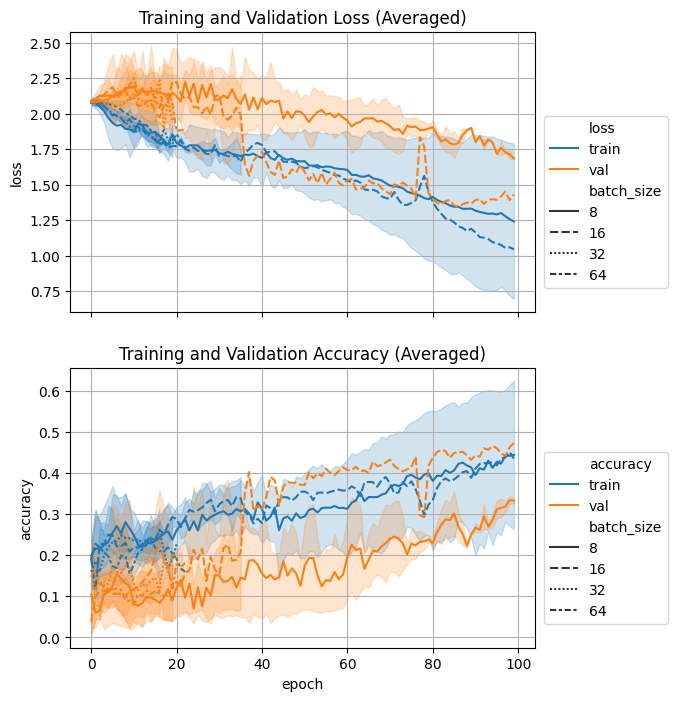

In [100]:
###########################
#  Combine log file data  #
###########################

logs = glob.glob(os.path.join(batch_size_study_folder, 'logs/*.log'))

study_df = pd.DataFrame()
for log in logs:
    base = os.path.basename(log)
    batch_size = int(base.split('_')[0][1:])
    fold = int((base.split('_')[1]).split('.')[0][1:])
   
    temp_df = pd.read_csv(os.path.join(batch_size_study_folder, 'logs/', os.path.basename(log)))
    temp_df['batch_size'] = batch_size
    temp_df['fold'] = fold

    if logs.index(log) == 0:
        study_df = temp_df.copy()  # initialize by copying
    else:
        study_df = pd.concat([study_df, temp_df], axis=0)


#################################
#  Organize dataframes to plot  #
#################################

study_df.rename({'accuracy' : 'train_accuracy', 'loss' : 'train_loss'}, axis=1, inplace=True)
study_df.sort_values(by=['batch_size'], inplace=True)  #ensure subplots are ascending in batch size

loss_df = study_df.drop(['train_accuracy', 'val_accuracy'], axis=1)
loss_df.rename({'train_loss' : 'train', 'val_loss' : 'val'}, axis=1, inplace=True)
loss_df = loss_df.melt(id_vars=['epoch', 'batch_size', 'fold'], value_vars=['train', 'val'], var_name='loss')

accuracy_df = study_df.drop(['train_loss', 'val_loss'], axis=1)
accuracy_df.rename({'train_accuracy' : 'train', 'val_accuracy' : 'val'}, axis=1, inplace=True)
accuracy_df = accuracy_df.melt(id_vars=['epoch', 'batch_size', 'fold'], value_vars=['train', 'val'], var_name='accuracy')


##########
#  Plot  #
##########

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,8))
sns.lineplot(ax=axs[0], data=loss_df, x='epoch', y='value', style='batch_size', hue='loss')
sns.lineplot(ax=axs[1], data=accuracy_df, x='epoch', y='value', style='batch_size', hue='accuracy')

axs[0].set_ylabel('loss')
axs[0].set_title('Training and Validation Loss (Averaged)')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Training and Validation Accuracy (Averaged)')

for ax in axs:
    ax.grid(True)

    #place legend outside center right border of plot
    ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0)

plt.show()

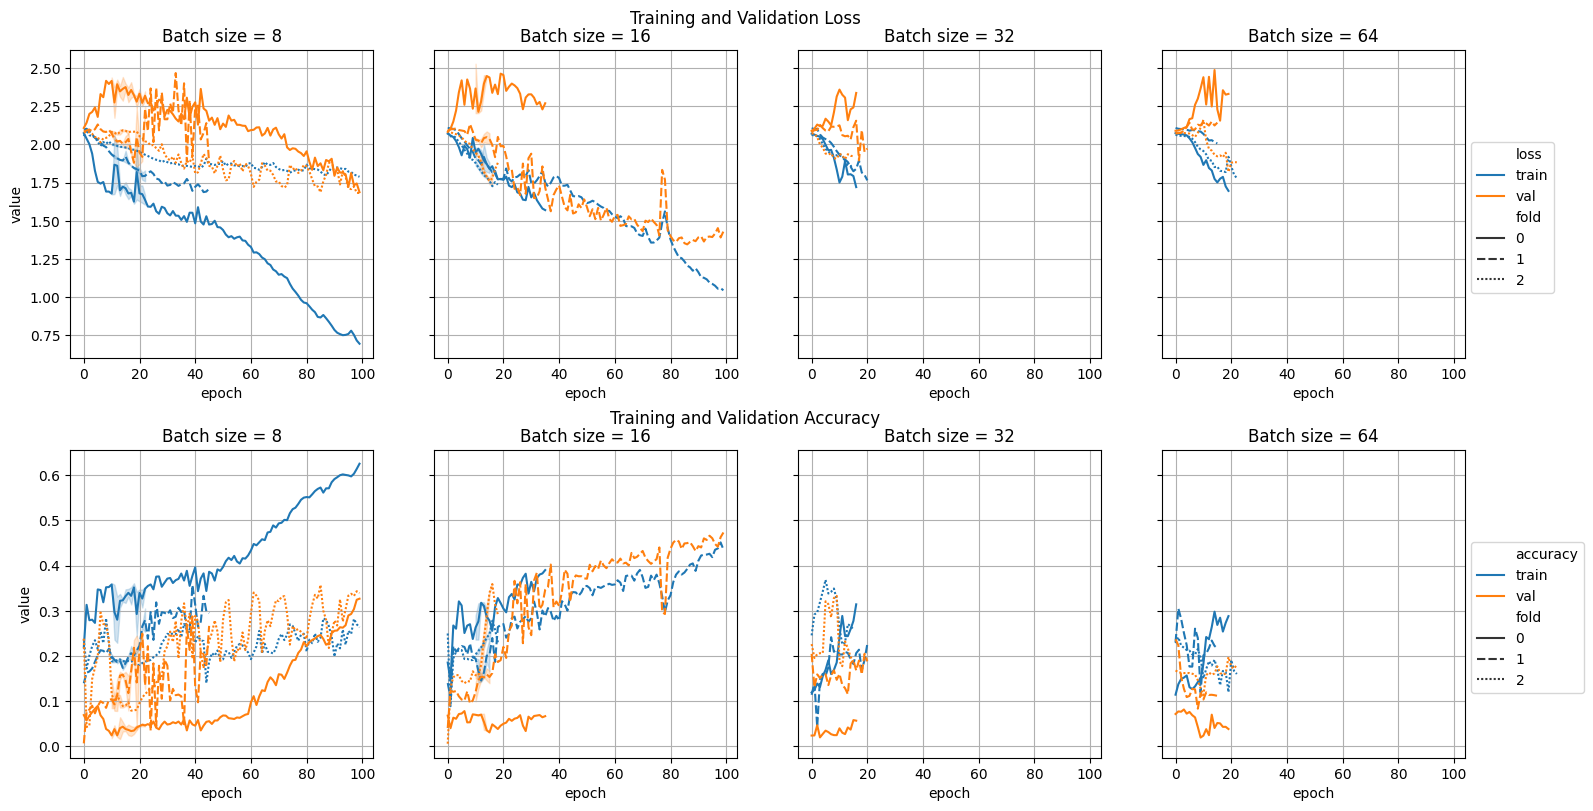

In [101]:
##########
#  Plot  #
##########

fig = plt.figure(figsize=(18, 8))
#fig.suptitle('title not used')

# create 2x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    if row == 0:
        subfig.suptitle('Training and Validation Loss')
        
        # create 1x3 subplots
        axs = subfig.subplots(nrows=1, ncols=len(loss_df['batch_size'].unique()), sharex=True, sharey='row')
        for col, ax in enumerate(axs):
            sns.lineplot(ax=ax, data=loss_df[loss_df['batch_size']==loss_df['batch_size'].unique()[col]] , x='epoch', y='value', style='fold', hue='loss')
            ax.set_title('Batch size = {}'.format(loss_df['batch_size'].unique()[col]))
            ax.grid(True)
            if col == len(study_df['batch_size'].unique()) - 1:
                #place legend outside center right border of plot
                ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0)
            else:
                ax.get_legend().remove()
    
    elif row == 1:
        subfig.suptitle('Training and Validation Accuracy')
        
        # create 1x3 subplots
        axs = subfig.subplots(nrows=1, ncols=len(accuracy_df['batch_size'].unique()), sharex=True, sharey='row')
        for col, ax in enumerate(axs):
            sns.lineplot(ax=ax, data=accuracy_df[accuracy_df['batch_size']==accuracy_df['batch_size'].unique()[col]] , x='epoch', y='value', style='fold', hue='accuracy')
            ax.set_title('Batch size = {}'.format(accuracy_df['batch_size'].unique()[col]))
            ax.grid(True)
            if col == len(study_df['batch_size'].unique()) - 1:
                #place legend outside center right border of plot
                ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0)
            else:
                ax.get_legend().remove()

From the data above, it appears that lower batch sizes are causing the model to have a stronger bias towards the training data and too large of a batch size causes the model to not improve. From this coarse grid, a batch size of 16 appears to train the model the best. The best model may not yet be at a converged solution as the loss appears to still be dropping.

### Learning Rate Study

In [49]:
learning_rates = [0.01, 0.1] #[0.0001, 0.001, 0.01, 0.1]  #default learning rate is 0.001
learning_rate_study_folder = '../learning_rate_study/'

#create directories
study_dir = os.path.dirname(learning_rate_study_folder)
if not os.path.isdir(study_dir):
    os.makedirs(study_dir)
    os.makedirs(study_dir+'/logs/')
    os.makedirs(study_dir+'/models/')

In [25]:
#if models exist, continue training if their epochs are less than what is declared for study, appending logs
models_list = glob.glob(os.path.join(learning_rate_study_folder, 'models/*.keras'))
models_list = [os.path.basename(p) for p in models_list]
if bool(models_list):
    learning_rate_list = []
    fold_list = []
    epoch_list = []
    for m in models_list:
        learning_rate_list.append(float("0." + m.split('_')[2]))
        fold_list.append(int(m.split('_')[4]))
        epoch_list.append(int((m.split('_')[6]).split('.')[0]))
    
    existing_models_df = pd.DataFrame({'name':models_list, 'learning_rate':learning_rate_list, 'fold':fold_list, 'epoch':epoch_list})

In [ ]:
#train model
model_exists = False  #initialize
e = 0  #initialize

for l in learning_rates:    
    for f in range(folds):
        #check for existing model
        if bool(models_list):
            matching_model = existing_models_df.loc[(existing_models_df['learning_rate'] == l) & (existing_models_df['fold'] == f)]
            if bool(matching_model.shape[0]):
                # get matching model with highest epoch
                matching_model = matching_model.loc[matching_model['epoch'] == matching_model['epoch'].max()]
                e = matching_model['epoch'].values[0]
                model_exists = True
        if model_exists:
            print(f"Continuing model training for learning_rate: {l}, fold: {f}, from epoch: {e}")
            model = load_model(os.path.join(learning_rate_study_folder + 'models/', matching_model['name'].values[0]))
        else:
            print(f"Training new model with learning rate: {l}, fold: {f}")
            #instantiate and compile model
            model = multi_class_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        #instantiate and compile model with modified optimizer
        model = multi_class_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)
        opt = Adam(learning_rate=l)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        
        #get cross-validation indices
        i_train, i_val = get_train_val_fold_split(indices_by_fold, f)
        
        #callbacks
        csv_logger = CSVLogger(learning_rate_study_folder + f"logs/L{str(l).split('.')[1]}_F{f}.log", separator=',', append=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=25)
        saver = CustomSaver_LearningRateStudy(learning_rate_study_folder, epochs, l, f)

        #train
        history = model.fit(image_input[i_train], mask_input[i_train],
                            batch_size=16,
                            verbose=2,
                            epochs=51,
                            validation_data=(image_input[i_val], mask_input[i_val]),
                            class_weight=class_weights_dict,
                            shuffle=False,
                            callbacks=[csv_logger, early_stopping, saver])

### Review Learning Rate Study Results

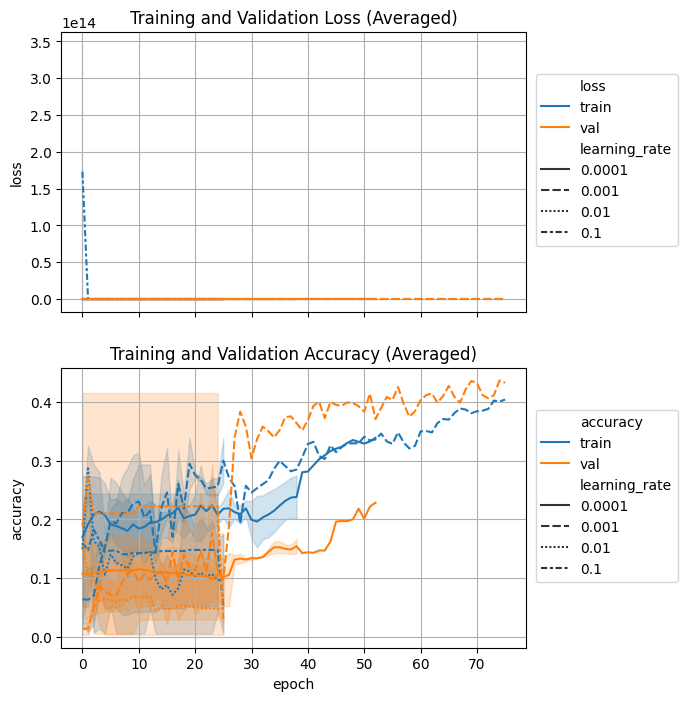

In [102]:
###########################
#  Combine log file data  #
###########################

logs = glob.glob(os.path.join(learning_rate_study_folder, 'logs/*.log'))

study_df = pd.DataFrame()
for log in logs:
    base = os.path.basename(log)
    learning_rate = float("0." + base.split('_')[0][1:])
    fold = int((base.split('_')[1]).split('.')[0][1:])
   
    temp_df = pd.read_csv(os.path.join(learning_rate_study_folder, 'logs/', os.path.basename(log)))
    temp_df['learning_rate'] = learning_rate
    temp_df['fold'] = fold

    if logs.index(log) == 0:
        study_df = temp_df.copy()  # initialize by copying
    else:
        study_df = pd.concat([study_df, temp_df], axis=0)


#################################
#  Organize dataframes to plot  #
#################################

study_df.rename({'accuracy' : 'train_accuracy', 'loss' : 'train_loss'}, axis=1, inplace=True)
study_df.sort_values(by=['learning_rate'], inplace=True)  #ensure subplots are ascending in learning rate

loss_df = study_df.drop(['train_accuracy', 'val_accuracy'], axis=1)
loss_df.rename({'train_loss' : 'train', 'val_loss' : 'val'}, axis=1, inplace=True)
loss_df = loss_df.melt(id_vars=['epoch', 'learning_rate', 'fold'], value_vars=['train', 'val'], var_name='loss')

accuracy_df = study_df.drop(['train_loss', 'val_loss'], axis=1)
accuracy_df.rename({'train_accuracy' : 'train', 'val_accuracy' : 'val'}, axis=1, inplace=True)
accuracy_df = accuracy_df.melt(id_vars=['epoch', 'learning_rate', 'fold'], value_vars=['train', 'val'], var_name='accuracy')


##########
#  Plot  #
##########

#palette = sns.color_palette("husl", len(loss_df['learning_rate'].unique()))

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,8))
sns.lineplot(ax=axs[0], data=loss_df, x='epoch', y='value', style='learning_rate', hue='loss')#, palette=palette)
sns.lineplot(ax=axs[1], data=accuracy_df, x='epoch', y='value', style='learning_rate', hue='accuracy')#, palette=palette)

axs[0].set_ylabel('loss')
axs[0].set_title('Training and Validation Loss (Averaged)')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Training and Validation Accuracy (Averaged)')

for ax in axs:  
    ax.grid(True)

    #place legend outside center right border of plot
    ax.legend(bbox_to_anchor=(1.02, 0.85), loc='upper left', borderaxespad=0)

plt.show()

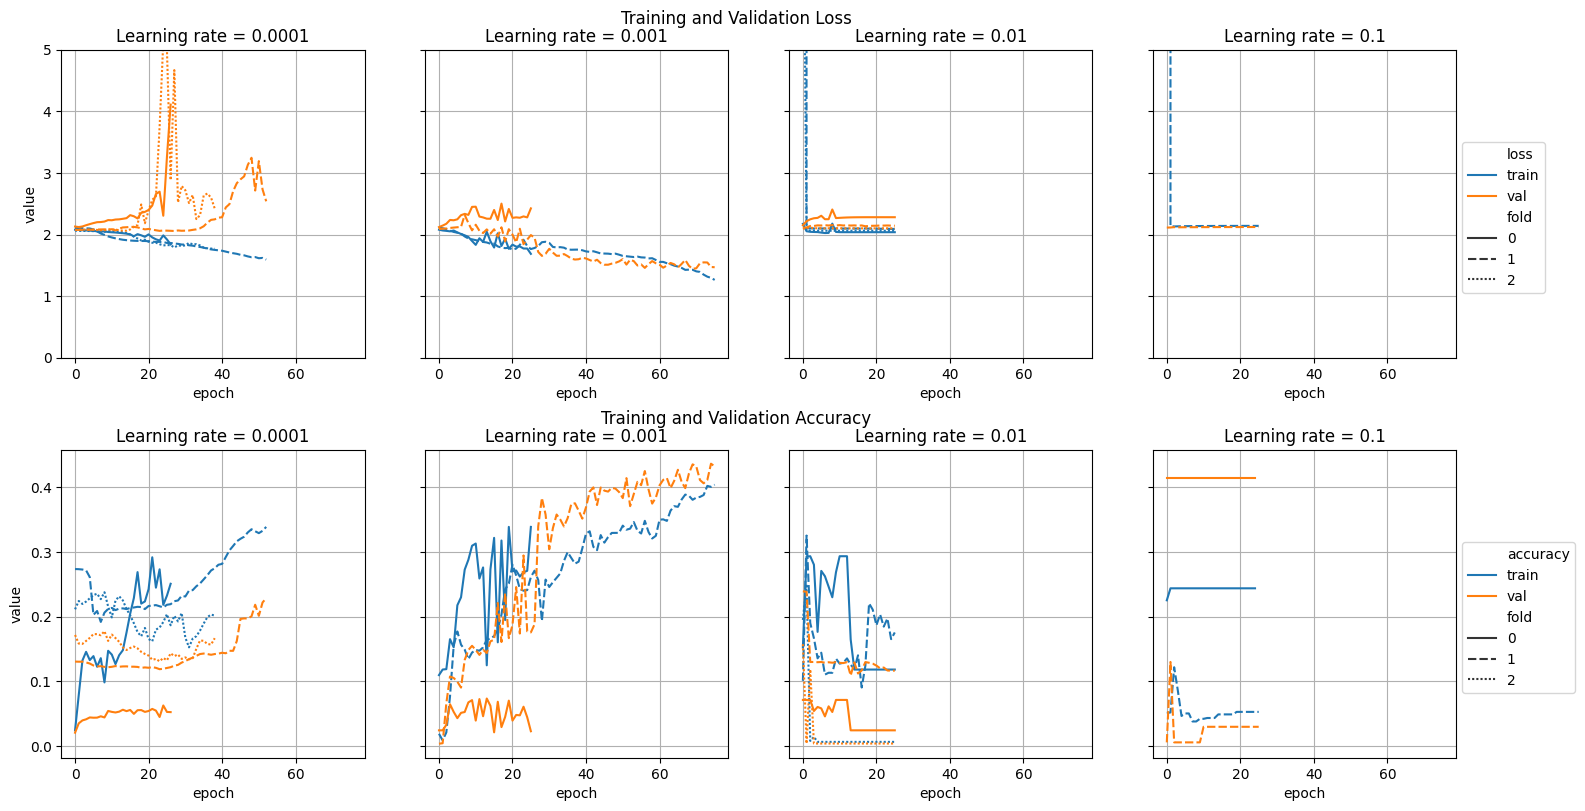

In [103]:
##########
#  Plot  #
##########

fig = plt.figure(figsize=(18, 8))
#fig.suptitle('title not used')

# create 2x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    if row == 0:
        subfig.suptitle('Training and Validation Loss')
        
        # create 1x3 subplots
        axs = subfig.subplots(nrows=1, ncols=len(loss_df['learning_rate'].unique()), sharex=True, sharey=True)
        for col, ax in enumerate(axs):
            sns.lineplot(ax=ax, data=loss_df[loss_df['learning_rate']==loss_df['learning_rate'].unique()[col]] , x='epoch', y='value', style='fold', hue='loss')
            ax.set_title('Learning rate = {}'.format(loss_df['learning_rate'].unique()[col]))
            ax.grid(True)
            ax.set_ylim([0,5])
            if col == len(study_df['learning_rate'].unique()) - 1:
                #place legend outside center right border of plot
                ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0)
            else:
                ax.get_legend().remove()
    
    elif row == 1:
        subfig.suptitle('Training and Validation Accuracy')
        
        # create 1x3 subplots
        axs = subfig.subplots(nrows=1, ncols=len(accuracy_df['learning_rate'].unique()), sharex=True, sharey='row')
        for col, ax in enumerate(axs):
            sns.lineplot(ax=ax, data=accuracy_df[accuracy_df['learning_rate']==accuracy_df['learning_rate'].unique()[col]] , x='epoch', y='value', style='fold', hue='accuracy')
            ax.set_title('Learning rate = {}'.format(accuracy_df['learning_rate'].unique()[col]))
            ax.grid(True)
            if col == len(study_df['learning_rate'].unique()) - 1:
                #place legend outside center right border of plot
                ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0)
            else:
                ax.get_legend().remove()

From the coarse learning rate study above, it appears that the default learning rate for the Adam optimizer, 0.001, is the best learning rate to use for training this model. Too low of a learning rate caused the model to train very slowly and/or not improve. Too large of a learning rate caused the model to not improve at all.

### Predictions using the best model

In [117]:
#filepaths
test_image_folder = "../data/Master/train/src/"
test_image_extension = ".jpeg"

test_mask_folder = "../data/Master/train/gt/"
test_mask_extension = ".bmp"

#load test data
test_image_input, test_mask_input, _, _ = load_image_and_mask_data(test_image_folder, test_image_extension,
                                                                                  test_mask_folder, test_mask_extension,
                                                                                  (SIZE_Y, SIZE_X))

Class labels in the dataset are ...  [0 1 2 3 4 5 6 7]
Number of classes in the dataset is ...  8
Class weights dictionary looks like ...: {0: 0.4153530814913036, 1: 4.132158105152629, 2: 0.9752438035103579, 3: 0.56284382246212, 4: 1.440754109554559, 5: 17.67116786746624, 6: 0.5698243009857589, 7: 23.40173041970236}


In [118]:
#load model
model = load_model(os.path.join(batch_size_study_folder, 'models/', 'model_bs_16_f_1_e_50.keras'))

#load training history
history = pd.read_csv(os.path.join(batch_size_study_folder, 'logs/', 'B16_F1.log'))

In [120]:
#############################
#  Intersection over Union  #
#############################

#Using built in keras function
from keras.metrics import MeanIoU
test_pred = model.predict(test_image_input)

19/19 [==============================] - 47s 2s/step


In [121]:
test_pred.shape

(600, 512, 512, 8)

In [123]:
test_pred_argmax = np.argmax(test_pred, axis=3)
test_pred_argmax.shape

(600, 512, 512)

In [124]:
test_mask_input.shape

(600, 512, 512, 8)

In [125]:
test_mask_argmax = np.argmax(test_mask_input, axis=3)
test_mask_argmax.shape

(600, 512, 512)

In [126]:
test_mask_expanded = np.expand_dims(test_mask_argmax, axis=3)
test_mask_expanded.shape

(600, 512, 512, 1)

In [130]:
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_mask_expanded[:,:,:,0], test_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.18807656


In [135]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[0,6] + values[0,7] + \
                          values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0] + values[6,0] + values[7,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[1,6] + values[1,7] + \
                          values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1] + values[6,1] + values[7,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[2,6] + values[2,7] + \
                          values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2] + values[6,2] + values[7,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[3,6] + values[3,7] + \
                          values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3] + values[6,3] + values[7,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] + values[4,6] + values[4,7] + \
                          values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4] + values[6,4] + values[7,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[5,6] + values[5,7] + \
                          values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5] + values[6,5] + values[7,5])
class7_IoU = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3] + values[6,4] + values[6,5] + values[6,7] + \
                          values[0,6] + values[1,6] + values[2,6] + values[3,6] + values[4,6] + values[5,6] + values[7,6])
class8_IoU = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3] + values[7,4] + values[7,5] + values[7,6] + \
                          values[0,7] + values[1,7] + values[2,7] + values[3,7] + values[4,7] + values[5,7] + values[6,7])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("IoU for class7 is: ", class7_IoU)
print("IoU for class8 is: ", class8_IoU)

IoU for class1 is:  0.17302337
IoU for class2 is:  0.08417059
IoU for class3 is:  0.0012001517
IoU for class4 is:  0.2691998
IoU for class5 is:  0.55908126
IoU for class6 is:  0.051858753
IoU for class7 is:  0.33498347
IoU for class8 is:  0.03109504


1/1 [==============================] - 0s 106ms/step


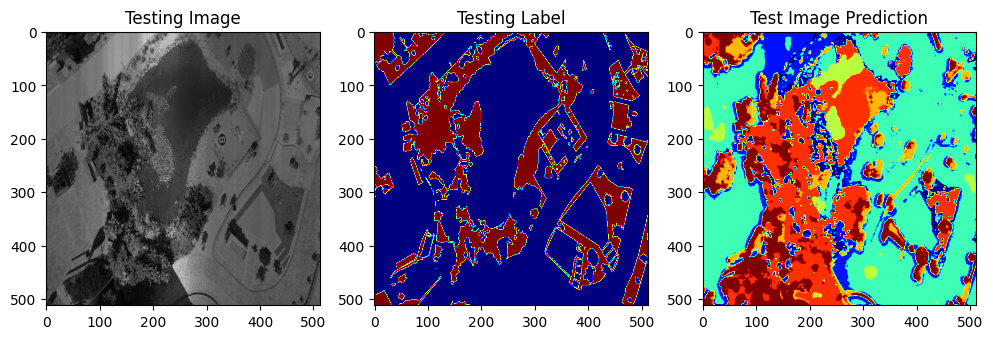

1/1 [==============================] - 0s 103ms/step


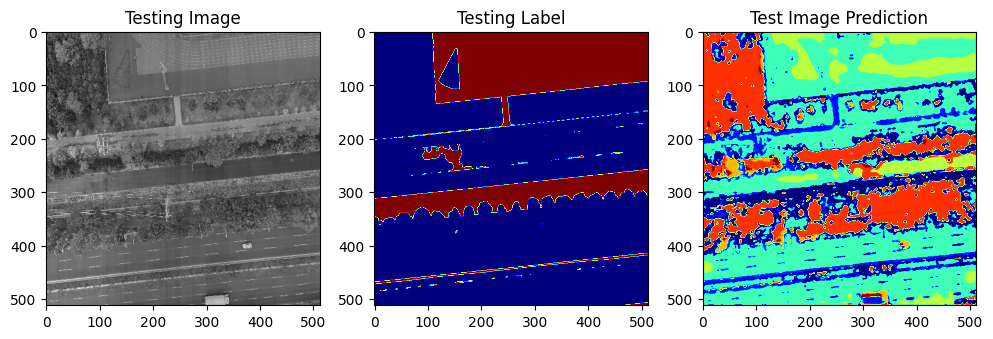

1/1 [==============================] - 0s 106ms/step


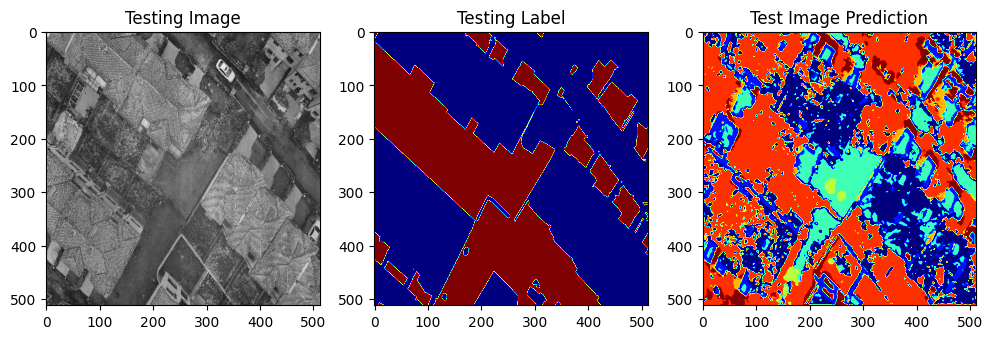

1/1 [==============================] - 0s 106ms/step


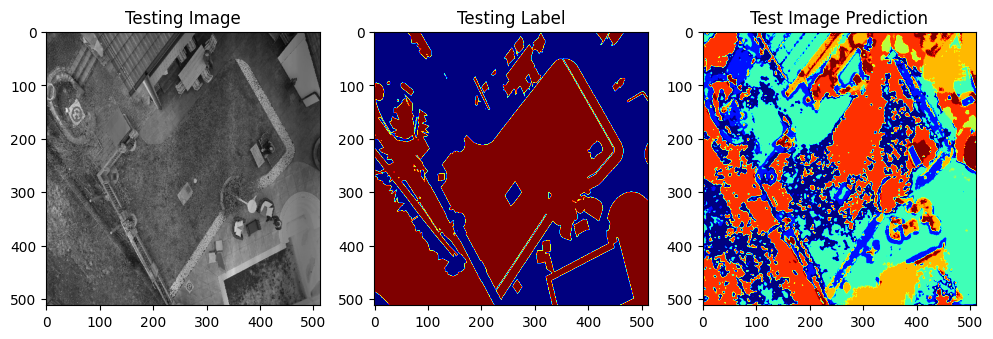

1/1 [==============================] - 0s 106ms/step


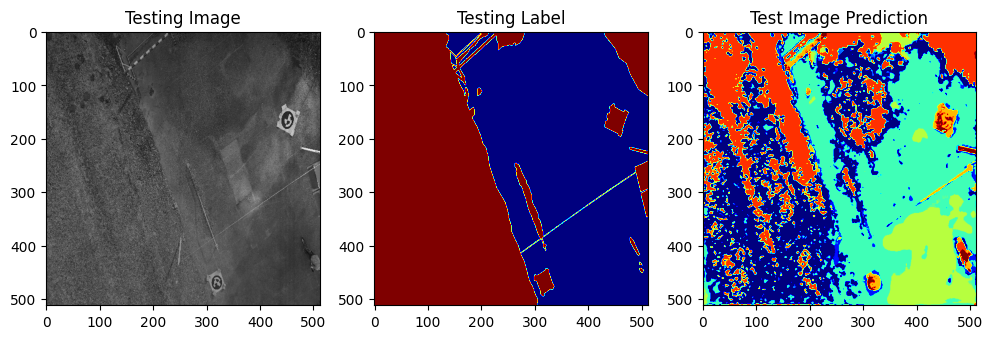

1/1 [==============================] - 0s 107ms/step


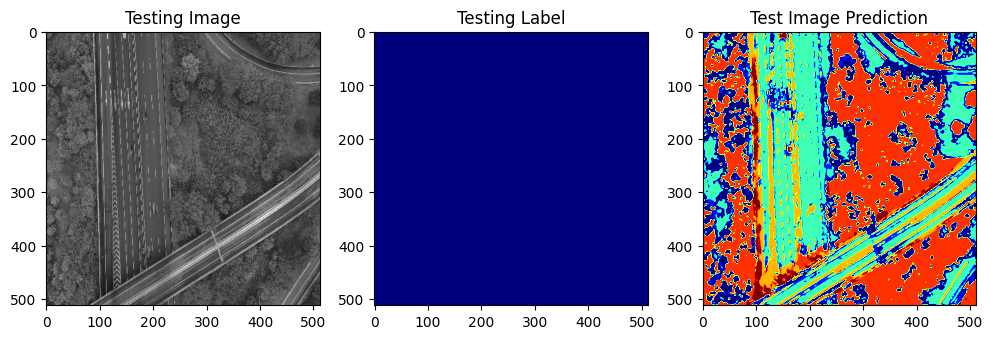

1/1 [==============================] - 0s 107ms/step


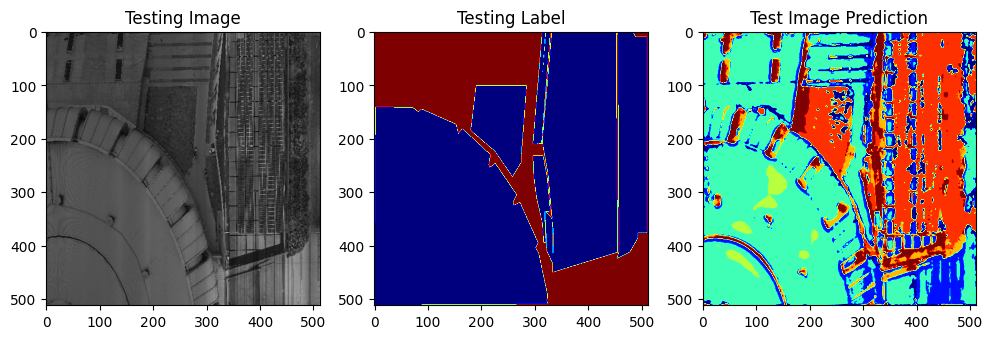

1/1 [==============================] - 0s 103ms/step


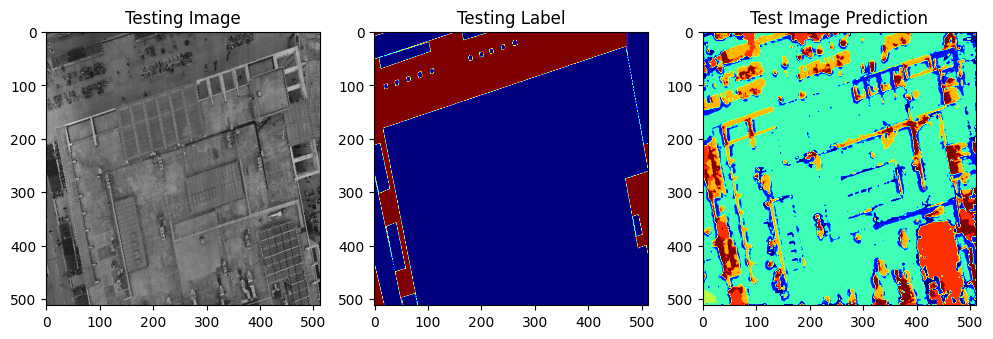

1/1 [==============================] - 0s 103ms/step


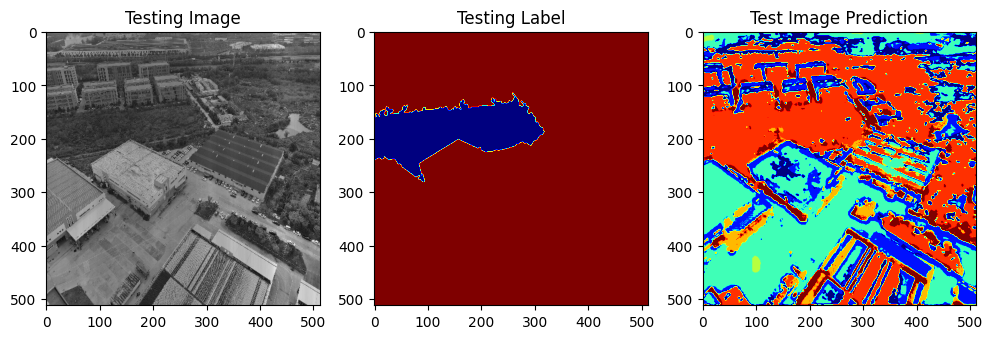

1/1 [==============================] - 0s 105ms/step


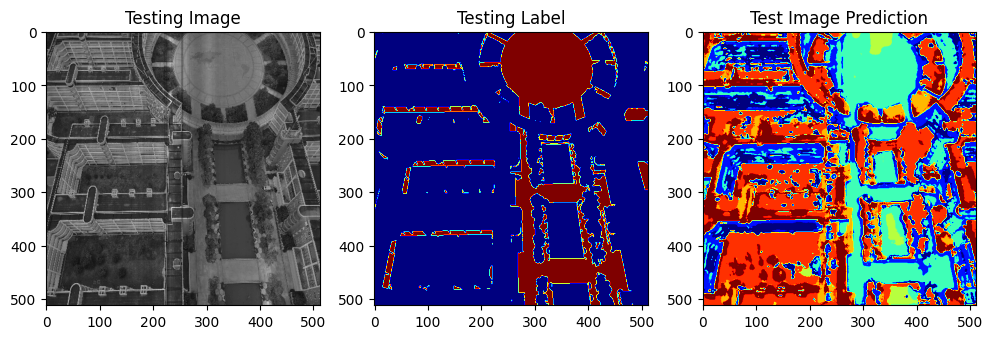

In [141]:
#############################
#  Predict on a few images  #
#############################

import random
n_predictions = 10

for n in range(n_predictions):
    i = random.randint(0, len(test_image_input))
    test_img = test_image_input[i]
    ground_truth = test_mask_input[i]
    test_img_norm = test_img[:,:,0][:,:,None]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]
    
    
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Test Image Prediction')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()


### Conclusion

The U-net architecture used for training this semantic segmentation model trained best with a batch size of 16 images and a learning rate of 0.001 for the Adam optimizer.

The predicted class accuracy (intersection over union) is very poor for classes 2, 3, 6, and 8 -- all well below 10% accuracy. Perhaps, combining poorly performing classes together into a composite class would improve model performance.

Furthermore, some masks appear to not label particular features well or at all (i.e. the roofs are not labeled as roofs in some of the test masks). This was overlooked during preprocessing.